# Realtime annotations

## Setup
Test the latency of realtime annotations on a GPU (if you have one) or a CPU.

In [2]:
import os
USE_GPU = True  # 
# disable existing GPUs if testing CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0' if USE_GPU else '-1'
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)

# disabling eager execution in tensorflow speeds up annotations by ~6x
try:
    import tensorflow as tf
    from tensorflow.python.framework.ops import disable_eager_execution
    disable_eager_execution()
except:
    pass

[]


In [3]:
%config InlineBackend.figure_format = 'jpg'  # smaller mem footprint for page

import numpy as np
import dss.utils
import dss.predict
import scipy.signal
import matplotlib.pyplot as plt
import scipy.io.wavfile
import time
import subprocess

plt.style.use('ncb.mplstyle')

## Load the model and runtime parameters

In [4]:
model_filename = 'models/dmel_single_rt/20200430_201821'
model, params = dss.utils.load_model_and_params(model_filename)

pulse_index = params['class_names'].index('pulse')
sine_index = params['class_names'].index('sine')

samplerate = params['samplerate_x_Hz']
interval = params['nb_hist'] / samplerate

print(f"Model expects input shape {model.input_shape[1]} samples and {model.input_shape[2]} channel(s).")

Model expects input shape 256 samples and 1 channel(s).


## Load a recording
Samplerates of the recording and of the data the model was trained with should match. Otherwise resample the recording to match the model using `scipy.signal.resample_poly(x=recording, up=int(recording_samplerate), down=int(samplerate), axis=0)`

In [5]:
recording_samplerate, recording = scipy.io.wavfile.read('dat/dmel_song_rt.wav')
recording = np.atleast_2d(recording).T

plt.figure(figsize=(30, 4))
plt.plot(recording[:100_000], c='k')  # plot the first 10 seconds
plt.show()

print(f"Sample rate of the recording ({recording_samplerate}Hz), sample rate expected by the model ({samplerate}Hz). Both should match.")

NameError: name 'scipy' is not defined

## Define a virtual microphone
The microphone takes a full recording and returns chunks of data at a rate determined by the chunk duration. In a real experimental setup, this would be a function that runs the data acquisition or a multi-processing queue that gets fed by the acquisition system.

In [2]:
def virtual_microphone(data: np.array, interval: float, samplerate: float, block: bool = True):
    
    RUN = True
    current_position = 0
    t1 = time.time() - 0.025
    t0 = time.time()    
    while RUN:
        current_position += interval * samplerate 
        start_sample = int(current_position)
        end_sample = int(current_position + interval * samplerate)
        chunk = data[start_sample:end_sample]
        if block:
            while (t1-t0)<interval:  # wait til interval has elapsed
                time.sleep(0.001)
                t1 = time.time()
        if end_sample >= data.shape[0]:
            RUN = False
            yield None
        else:
            yield chunk
        t0 = time.time()
    

mike = virtual_microphone(recording, interval, samplerate, block=True)
rec = next(mike)
print(f"Microphone produces {rec.shape[0]} samples and {rec.shape[1]} channel(s) per chunk.")

print('Consuming and plotting 100 chunks...')
recording_latencies = []
for _ in range(100):
    with dss.utils.Timer() as t:
        rec = next(mike)
    recording_latencies.append(t.elapsed * 1000)
    plt.plot(rec)
    plt.ylim(-1, 1)
plt.title('Individal chunks')
plt.xlabel('Samples')
plt.xlim(0, rec.shape[0])
plt.show()
print(f"Takes {np.median(recording_latencies):1.1f} ms to return {rec.shape[0] / samplerate * 1000:1.1f} ms of audio data.")

NameError: name 'np' is not defined

## Test annotation
Test the model and a simple song detection routing with a chunk that contains song. A specific song type is detect if the corresponding confidence is exceeds 0.7 during a chunk.

In [4]:
def report_song(prediction, pulse_index, sine_index):
    report = 'pulse? ' + ('yes' if np.max(out[:, pulse_index]) > 0.7 else ' no')
    report += ' sine? ' + ('yes' if np.max(out[:, sine_index]) > 0.7 else ' no')
    return report

# consume a couple of chunks until there is song
for _ in range(9):
    d = next(mike)

d = d[np.newaxis, ...]
out = model.predict(d, verbose=0)

plt.subplot(211)
plt.plot(d[0, ...])
plt.ylabel('Audio [V]')
plt.subplot(212)
plt.plot(out[0])
plt.ylabel('Confidence\nscore')
plt.xlabel('Samples')
plt.legend(params['class_names'])


NameError: name 'mike' is not defined

## Run annotation
Run the virtual microphone for 100 chunks to estimate annotation latencies.

In [14]:
latencies = []
runs = 0

while runs < 100:
    runs += 1
    with dss.utils.Timer() as dt:
        d = next(mike)  # get a new chunk
        d = d[np.newaxis, ...]
        out = model.predict(d, verbose=0)  # run inference on the chunk
        # detect pulse and sine
        result = report_song(out[0, ...], pulse_index, sine_index)
        # print(result)
    latencies.append(dt.elapsed * 1000)


pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no sine?  no
pulse?  no sine? yes
pulse?  no sine?  no
pulse? yes sine? yes
pulse? yes sine? yes
pulse? yes sine? yes
pulse?  no si

## Evaluate latencies
Timing on GPUs can be more variable than on CPUs since a major contributor to latency is the transfer of data from/to the GPU.
Hence, warmup!

Subtract the recording latency to get 

Annotation latencies
  5, 50, 95 percentiles: [4.4279488 5.0589635 5.8320642] ms
  min 3.90 ms, max 6.00 ms


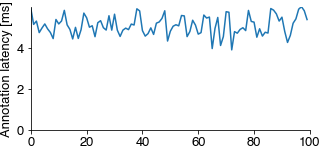

In [13]:
annotation_latencies = np.array(latencies) - np.median(recording_latencies)
print('Annotation latencies')
print(f'  5, 50, 95 percentiles: {np.percentile(annotation_latencies, [5, 50, 95])} ms')
print(f'  min {np.min(annotation_latencies):1.2f} ms, max {np.max(annotation_latencies):1.2f} ms')

plt.figure(figsize=(5, 5))
plt.plot(np.array(annotation_latencies))
plt.ylabel('Annotation latency [ms]')
plt.xlabel('Chunk#')
plt.ylim(0, np.max(annotation_latencies))
plt.show()